In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import ADASYN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from CHAID import Tree
from optbinning import OptimalBinning
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor

from hyperopt import fmin, hp, tpe, Trials
from hyperopt.pyll.base import scope
from functools import partial
from hyperopt import base
base.have_bson = False

In [29]:
df = pd.read_csv('_BANKRUPTCY PREDICTION .csv')

In [30]:
df_copy = df.copy()

In [31]:
cols = [' Interest-bearing debt interest rate', ' Current Ratio', ' Revenue Per Share (Yuan �', 
        ' Fixed Assets to Assets', ' Revenue per person', ' Quick Assets/Current Liability', 
        ' Quick Ratio', ' Net Value Growth Rate', ' Long-term Liability to Current Assets', 
        ' Allocation rate per person', ' Cash/Current Liability', ' Average Collection Days', 
        ' Accounts Receivable Turnover', ' Total assets to GNP price', ' Inventory/Current Liability', 
        ' Total debt/Total net worth', ' Research and development expense rate', ' Operating Expense Rate', 
        ' Total Asset Growth Rate', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', 
        ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate',
        ' Research and development expense rate', ' Inventory Turnover Rate (times)']
target = 'Bankrupt'

In [32]:
df_copy.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [33]:
def winsorize_data(frame, independent_cols, target):
    for col in independent_cols:
        if col != target:
        
            frame[col+'_1'] = winsorize(frame[col], limits=(0.01, 0.01))
            frame[col+'_3'] = winsorize(frame[col], limits=(0.03, 0.03))
            frame[col+'_5'] = winsorize(frame[col], limits=(0.05, 0.05))
 
    return frame

In [34]:
frame = winsorize_data(df_copy, cols, target)
frame

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Fixed Assets Turnover Frequency_5,Current Asset Turnover Rate_1,Current Asset Turnover Rate_3,Current Asset Turnover Rate_5,Quick Asset Turnover Rate_1,Quick Asset Turnover Rate_3,Quick Asset Turnover Rate_5,Cash Turnover Rate_1,Cash Turnover Rate_3,Cash Turnover Rate_5
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,1.217960e-04,7.010000e+08,7.010000e+08,7.010000e+08,6.550000e+09,6.550000e+09,6.550000e+09,4.580000e+08,4.580000e+08,4.580000e+08
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,7.190000e+08,1.065200e-04,1.065200e-04,1.099150e-04,7.700000e+09,7.700000e+09,7.700000e+09,2.490000e+09,2.490000e+09,2.490000e+09
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,2.650000e+09,1.791094e-03,1.791094e-03,1.791094e-03,1.022676e-03,1.022676e-03,1.022676e-03,7.610000e+08,7.610000e+08,7.610000e+08
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,7.790000e+09,8.140000e+09,8.140000e+09,8.140000e+09,6.050000e+09,6.050000e+09,6.050000e+09,2.030000e+09,2.030000e+09,2.030000e+09
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,2.935210e-04,6.680000e+09,6.680000e+09,6.680000e+09,5.050000e+09,5.050000e+09,5.050000e+09,8.240000e+08,8.240000e+08,8.240000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,1.429780e-04,2.294150e-04,2.294150e-04,2.294150e-04,1.244230e-04,1.244230e-04,1.244230e-04,1.077940e-04,1.101890e-04,1.172740e-04
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,6.051980e-04,1.517300e-04,1.517300e-04,1.517300e-04,1.173400e-04,1.173400e-04,1.173400e-04,7.710000e+09,7.710000e+09,7.710000e+09
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,1.024298e-03,1.762270e-04,1.762270e-04,1.762270e-04,1.749710e-04,1.749710e-04,1.749710e-04,4.074260e-04,4.074260e-04,4.074260e-04
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,2.330010e-04,2.135940e-04,2.135940e-04,2.135940e-04,1.351940e-04,1.351940e-04,1.351940e-04,1.165390e-04,1.165390e-04,1.172740e-04


In [6]:
tree = Tree.from_pandas_df(df_copy, dict(zip(cols, 
                                        ['nominal']*len(cols))), d_variable='Bankrupt', max_depth=7)

In [8]:
tree.print_tree()

KeyboardInterrupt: 

In [7]:
bin_dict = {}
for node in tree.tree_store:
    if node.is_terminal:
        parent_node_id = node.parent
        parent_node = next(n for n in tree.tree_store if n.node_id == parent_node_id)
        split_variable = parent_node.split_variable
        bins = node.choices
        bin_dict[split_variable] = bins

KeyboardInterrupt: 

In [ ]:
for col, bins in bin_dict.items():
    frame[col + '_bins_CHAID'] = pd.cut(frame[col], bins, labels=False)

In [48]:
def remove_multicollinearity(data, target, vif_threshold=10):
    def calculate_vif(X, col):
        if col != target:
            vif = pd.DataFrame()
            vif["features"] = X.columns
            vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            vif = vif.sort_values(ascending=False, by='VIF')
            return vif

    features = data.select_dtypes(include=np.number)
    dropped_columns = []
    for col in features.columns:
        vif = calculate_vif(features, col)
        if vif is not None and vif["VIF"].max() > vif_threshold:
            remove_feature = vif.loc[vif["VIF"].idxmax()]["features"]
            data.drop(columns=[remove_feature], axis=1, inplace=True)
            dropped_columns.append(remove_feature)
            features = data.select_dtypes(include=np.number)
    return data, dropped_columns

In [49]:
target = "Bankrupt"
df_copy, dropped_cols = remove_multicollinearity(df_copy, target)

KeyboardInterrupt: 

In [35]:
frame.shape

(6819, 167)

In [17]:
dropped_cols

NameError: name 'dropped_cols' is not defined

In [36]:
X = frame.drop('Bankrupt', axis=1)
y = frame['Bankrupt']

In [37]:
X_resampled, y_resampled = ADASYN(sampling_strategy='minority').fit_resample(X, y)

In [ ]:
cols = [' Interest-bearing debt interest rate', ' Current Ratio', ' Revenue Per Share (Yuan �', 
        ' Fixed Assets to Assets', ' Revenue per person', ' Quick Assets/Current Liability', 
        ' Quick Ratio', ' Net Value Growth Rate', ' Long-term Liability to Current Assets', 
        ' Allocation rate per person', ' Cash/Current Liability', ' Average Collection Days', 
        ' Accounts Receivable Turnover', ' Total assets to GNP price', ' Inventory/Current Liability', 
        ' Total debt/Total net worth', ' Research and development expense rate', ' Operating Expense Rate', 
        ' Total Asset Growth Rate', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', 
        ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate',
        ' Research and development expense rate', ' Inventory Turnover Rate (times)']

In [ ]:
def preprocess(frame, independent_cols, target=None):

    for col in independent_cols:
        if target:
            frame[col+'_winsorized'] = winsorize(frame[col], limits=(0.01, 0.01))
            ob = OptimalBinning(name=col, dtype="numerical", prebinning_method ='cart', solver="cp")
            ob.fit(frame[col], frame[target])
            transformed_col = ob.transform(frame[col])

            frame[col] = transformed_col
        else:
            continue
            
    return frame

In [ ]:
target_col = "Bankrupt"
independent_cols = cols
X_resampled = preprocess(X_resampled, independent_cols)

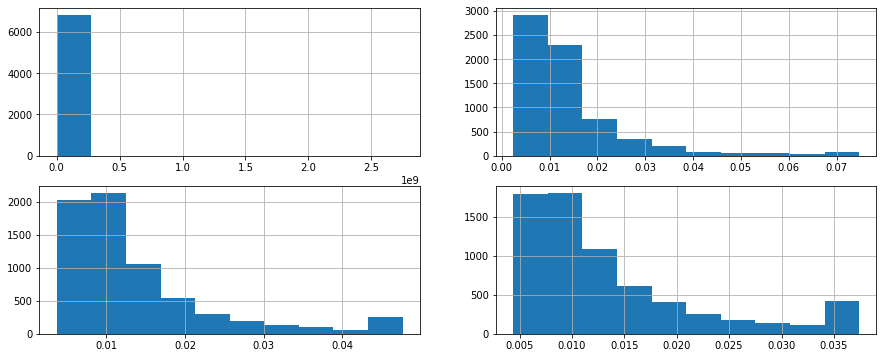

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(15, 6))
frame[' Current Ratio'].hist(ax=ax[0][0])
frame[' Current Ratio_1'].hist(ax=ax[0][1])
frame[' Current Ratio_3'].hist(ax=ax[1][0])
frame[' Current Ratio_5'].hist(ax=ax[1][1])
plt.show()

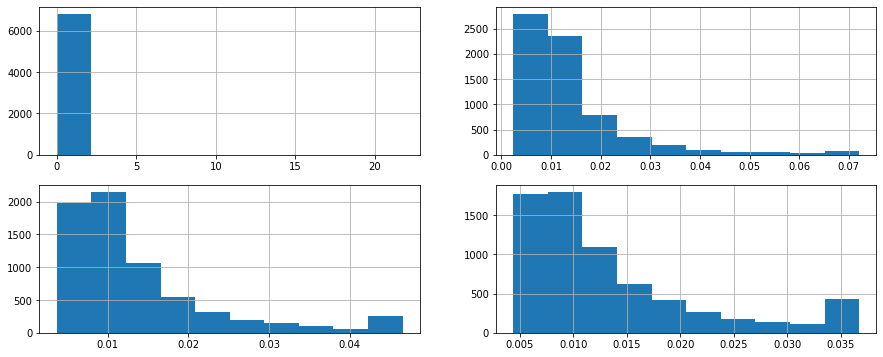

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(15, 6))
np.log1p(frame[' Current Ratio']).hist(ax=ax[0][0])
np.log1p(frame[' Current Ratio_1']).hist(ax=ax[0][1])
np.log1p(frame[' Current Ratio_3']).hist(ax=ax[1][0])
np.log1p(frame[' Current Ratio_5']).hist(ax=ax[1][1])
plt.show()

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '-0.4658291976069326'),
  Text(1, 0, '-0.2501430137490654'),
  Text(2, 0, '0.00015152663109526586'),
  Text(3, 0, '0.09848742735195706'),
  Text(4, 0, '0.1779584030705232'),
  Text(5, 0, '0.3276550932695479'),
  Text(6, 0, '1.032742714201411')])

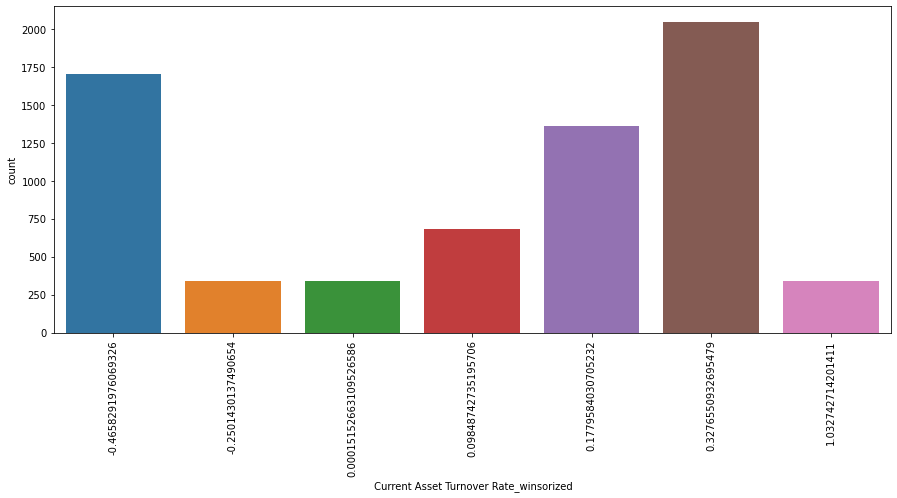

In [38]:
plt.figure(figsize=(15, 6))
sns.countplot(data=data, x=' Current Asset Turnover Rate_winsorized')
plt.xticks(rotation=90)

In [24]:
data.groupby('Bankrupt')[' Current Asset Turnover Rate_winsorized'].agg(['mean', 'median'])

,mean,median
Bankrupt,,
0,0.070910,0.177958
1,-0.068859,0.000152


In [26]:
data.groupby('Bankrupt')[' Current Asset Turnover Rate_winsorized'].value_counts()

Bankrupt   Current Asset Turnover Rate_winsorized
0          0.327655                                  1998
          -0.465829                                  1619
           0.177958                                  1326
           0.098487                                   662
           1.032743                                   337
           0.000152                                   330
          -0.250143                                   327
1         -0.465829                                    86
           0.327655                                    48
           0.177958                                    37
           0.098487                                    20
          -0.250143                                    14
           0.000152                                    11
           1.032743                                     4
Name:  Current Asset Turnover Rate_winsorized, dtype: int64

In [16]:
results = []
for col in independent_cols:
    if col != target_col:
        score_ls = []
        score_std_ls = []
        for tree_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
            tree_model = DecisionTreeClassifier(max_depth=tree_depth)

            scores = cross_val_score(tree_model, data[[col]],
                                     data[target_col], cv=5, scoring="roc_auc")

            score_ls.append(np.mean(scores))
            score_std_ls.append(np.std(scores))

        col_results = {
            "column": col,
            "depth": list(range(1, 12)),
            "roc_auc_mean": score_ls,
            "roc_auc_std": score_std_ls,
        }

        results.append(col_results)

results_df = pd.concat([pd.DataFrame(r) for r in results], ignore_index=True)

print(results_df)

                                   column  depth  roc_auc_mean  roc_auc_std
0     Interest-bearing debt interest rate      1      0.665675     0.038829
1     Interest-bearing debt interest rate      2      0.715885     0.038665
2     Interest-bearing debt interest rate      3      0.737164     0.036647
3     Interest-bearing debt interest rate      4      0.741976     0.037094
4     Interest-bearing debt interest rate      5      0.742150     0.036318
..                                    ...    ...           ...          ...
281       Inventory Turnover Rate (times)      7      0.556899     0.039091
282       Inventory Turnover Rate (times)      8      0.556899     0.039091
283       Inventory Turnover Rate (times)      9      0.556899     0.039091
284       Inventory Turnover Rate (times)     10      0.556899     0.039091
285       Inventory Turnover Rate (times)     11      0.556899     0.039091

[286 rows x 4 columns]


In [17]:
def preprocess(col_name, max_depth=None):
    tree_model = DecisionTreeClassifier(max_depth=max_depth)
    tree_model.fit(X[[col_name]], y)
    X[col_name+'_Tree'] = tree_model.predict_proba(X[[col_name]])[:,1]
    return X

In [18]:
from tqdm import tqdm

for col in tqdm(results_df['column'].unique()):
    rows = results_df['column'] == col
    col_data = results_df.loc[rows, ['column', 'roc_auc_mean', 'roc_auc_std', 'depth']]
    max_idx = col_data['roc_auc_mean'].idxmax()
    max_depth = col_data.loc[max_idx, 'depth']
    print(f"{col}: max score at depth {max_depth}")

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 605.66it/s]

 Interest-bearing debt interest rate: max score at depth 5
 Current Ratio: max score at depth 6
 Revenue Per Share (Yuan �: max score at depth 6
 Fixed Assets to Assets: max score at depth 3
 Revenue per person: max score at depth 3
 Quick Assets/Current Liability: max score at depth 6
 Quick Ratio: max score at depth 3
 Net Value Growth Rate: max score at depth 3
 Long-term Liability to Current Assets: max score at depth 5
 Allocation rate per person: max score at depth 4
 Cash/Current Liability: max score at depth 3
 Average Collection Days: max score at depth 4
 Accounts Receivable Turnover: max score at depth 5
 Total assets to GNP price: max score at depth 3
 Inventory/Current Liability: max score at depth 1
 Total debt/Total net worth: max score at depth 4
 Research and development expense rate: max score at depth 2
 Operating Expense Rate: max score at depth 2
 Total Asset Growth Rate: max score at depth 4
 Inventory Turnover Rate (times): max score at depth 2
 Fixed Assets Turn

In [29]:
max_depths = {
    ' Interest-bearing debt interest rate': 5,
    ' Current Ratio': 6,
    ' Revenue Per Share (Yuan �': 6,
    ' Fixed Assets to Assets': 3,
    ' Revenue per person': 3,
    ' Quick Assets/Current Liability': 6,
    ' Quick Ratio': 3,
    ' Net Value Growth Rate': 3,
    ' Long-term Liability to Current Assets': 5,
    ' Allocation rate per person': 4,
    ' Cash/Current Liability': 3,
    ' Average Collection Days': 4,
    ' Accounts Receivable Turnover': 5,
    ' Total assets to GNP price': 3,
    ' Inventory/Current Liability': 1,
    ' Total debt/Total net worth': 4,
    ' Research and development expense rate': 2,
    ' Operating Expense Rate': 2,
    ' Total Asset Growth Rate': 4,
    ' Inventory Turnover Rate (times)': 2,
    ' Fixed Assets Turnover Frequency': 3,
    ' Current Asset Turnover Rate': 3,
    ' Quick Asset Turnover Rate': 2,
    ' Cash Turnover Rate': 3
}

for col, depth in max_depths.items():
    X_resampled = preprocess(col, max_depth=depth)

In [32]:
X_resampled[' Current Asset Turnover Rate_Tree'].value_counts()

0.022250    3191
0.028262    1663
0.056618    1360
0.024590     488
0.053571      56
0.122449      49
0.166667       6
0.500000       6
Name:  Current Asset Turnover Rate_Tree, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '0.022250078345346286'),
  Text(1, 0, '0.02459016393442623'),
  Text(2, 0, '0.02826217678893566'),
  Text(3, 0, '0.05357142857142857'),
  Text(4, 0, '0.05661764705882353'),
  Text(5, 0, '0.12244897959183673'),
  Text(6, 0, '0.16666666666666666'),
  Text(7, 0, '0.5')])

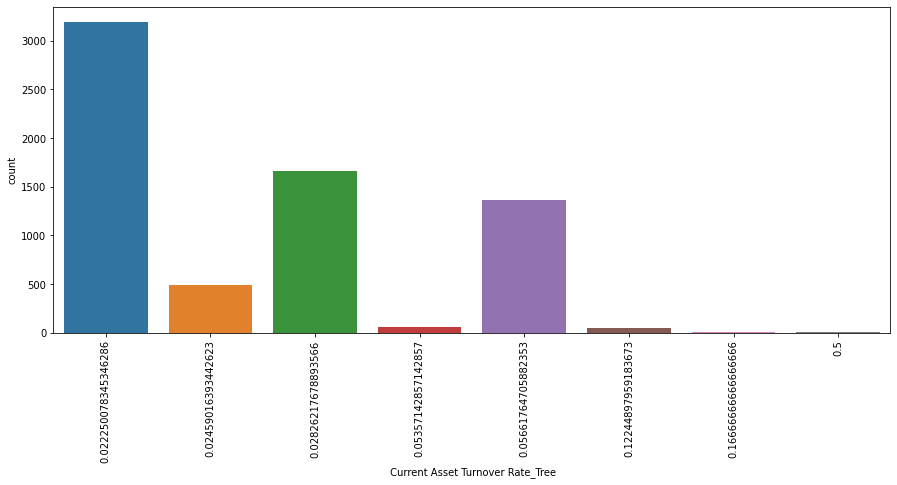

In [37]:
plt.figure(figsize=(15, 6))
sns.countplot(data=X_resampled, x=' Current Asset Turnover Rate_Tree')
plt.xticks(rotation=90)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [52]:
X_train = X_train.loc[:, ~X_train.columns.str.contains('_winsorized')]
X_train = X_train.drop(cols, axis=1)
X_train

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Fixed Assets Turnover Frequency_5,Current Asset Turnover Rate_1,Current Asset Turnover Rate_3,Current Asset Turnover Rate_5,Quick Asset Turnover Rate_1,Quick Asset Turnover Rate_3,Quick Asset Turnover Rate_5,Cash Turnover Rate_1,Cash Turnover Rate_3,Cash Turnover Rate_5
3039,0.552186,0.598942,0.591948,0.607079,0.606970,0.999081,0.797537,0.809418,0.303549,0.781686,...,4.569250e-04,1.021930e-04,1.058290e-04,1.099150e-04,6.970000e+09,6.970000e+09,6.970000e+09,4.550000e+09,4.550000e+09,4.550000e+09
11845,0.358474,0.394846,0.386759,0.581812,0.581812,0.998462,0.796669,0.808617,0.303326,0.780725,...,1.954618e-04,2.244968e-04,2.244968e-04,2.244968e-04,1.447318e-04,1.447318e-04,1.447318e-04,1.556687e-04,1.556687e-04,1.556687e-04
1801,0.626920,0.658908,0.656299,0.619316,0.619316,0.999100,0.798163,0.809891,0.304600,0.782188,...,1.724810e-04,2.459750e-04,2.459750e-04,2.459750e-04,2.424100e-04,2.424100e-04,2.424100e-04,1.593780e-04,1.593780e-04,1.593780e-04
4377,0.500561,0.561273,0.549333,0.599324,0.599439,0.998960,0.797634,0.809497,0.303971,0.781779,...,8.412250e-04,1.808010e-04,1.808010e-04,1.808010e-04,1.915060e-04,1.915060e-04,1.915060e-04,1.425720e-04,1.425720e-04,1.425720e-04
5875,0.531858,0.588694,0.584667,0.611907,0.612354,0.999139,0.797605,0.809497,0.303544,0.781769,...,1.929070e-04,2.218080e-04,2.218080e-04,2.218080e-04,1.828880e-04,1.828880e-04,1.828880e-04,1.953400e-04,1.953400e-04,1.953400e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8536,0.438079,0.487733,0.486310,0.599081,0.599081,0.998945,0.797159,0.809091,0.303171,0.781319,...,1.217960e-04,2.184506e+08,2.184506e+08,2.184506e+08,4.698277e+09,4.698277e+09,4.698277e+09,8.724005e+08,8.724005e+08,8.724005e+08
10846,0.404616,0.436795,0.460146,0.588794,0.588794,0.998859,0.797261,0.809203,0.303530,0.781449,...,2.820891e-04,3.121931e+08,3.121931e+08,3.121931e+08,8.725398e+08,8.725398e+08,8.725398e+08,1.974555e+09,1.974555e+09,1.974555e+09
434,0.407059,0.461731,0.453986,0.611439,0.611439,0.998753,0.796840,0.808799,0.303017,0.781052,...,1.286050e-04,2.262820e-04,2.262820e-04,2.262820e-04,1.895100e-04,1.895100e-04,1.895100e-04,4.450000e+09,4.450000e+09,4.450000e+09
13154,0.460324,0.554808,0.513324,0.599980,0.599980,0.998940,0.797609,0.809544,0.303968,0.781533,...,5.522368e-04,9.386507e-04,9.386507e-04,9.386507e-04,1.328553e-04,1.328553e-04,1.328553e-04,1.948701e+09,1.948701e+09,1.948701e+09


In [53]:
X_test = X_test.loc[:, ~X_test.columns.str.contains('_winsorized')]
X_test = X_test.drop(cols, axis=1)
X_test

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Fixed Assets Turnover Frequency_5,Current Asset Turnover Rate_1,Current Asset Turnover Rate_3,Current Asset Turnover Rate_5,Quick Asset Turnover Rate_1,Quick Asset Turnover Rate_3,Quick Asset Turnover Rate_5,Cash Turnover Rate_1,Cash Turnover Rate_3,Cash Turnover Rate_5
4966,0.419636,0.473288,0.463997,0.599266,0.599266,0.998955,0.797017,0.808965,0.302903,0.781196,...,2.193840e-04,1.889580e-04,1.889580e-04,1.889580e-04,1.082760e-04,1.082760e-04,1.083990e-04,1.970000e+09,1.970000e+09,1.970000e+09
9405,0.406935,0.452876,0.449249,0.606367,0.606367,0.998818,0.797141,0.809070,0.303406,0.781307,...,2.383139e-04,2.234398e-04,2.234398e-04,2.234398e-04,1.598927e-04,1.598927e-04,1.598927e-04,3.003064e+09,3.003064e+09,3.003064e+09
4622,0.396188,0.455789,0.455860,0.596600,0.596600,0.998466,0.795514,0.807911,0.301299,0.780086,...,3.710000e+09,1.792441e-03,1.792441e-03,1.792441e-03,1.727771e-03,1.727771e-03,1.727771e-03,1.820141e-03,1.820141e-03,1.820141e-03
3852,0.405011,0.456116,0.448686,0.604052,0.604052,0.998828,0.797203,0.809142,0.303494,0.781387,...,2.351951e-03,1.422900e-04,1.422900e-04,1.422900e-04,6.730000e+09,6.730000e+09,6.730000e+09,2.640000e+09,2.640000e+09,2.640000e+09
8483,0.505558,0.561199,0.561076,0.599832,0.599832,0.999044,0.797417,0.809339,0.303416,0.781607,...,1.527016e-03,6.226803e+09,6.226803e+09,6.226803e+09,4.930068e+07,4.930068e+07,4.930068e+07,8.583039e+07,8.583039e+07,8.583039e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,0.534442,0.591201,0.576262,0.608282,0.608044,0.999085,0.797615,0.809478,0.303676,0.781746,...,7.330460e-04,1.780510e-04,1.780510e-04,1.780510e-04,1.405320e-04,1.405320e-04,1.405320e-04,3.410000e+09,3.410000e+09,3.410000e+09
13039,0.420164,0.438364,0.463583,0.612275,0.612275,0.998863,0.796911,0.808866,0.302911,0.781253,...,1.580702e-04,3.084390e-04,3.084390e-04,3.084390e-04,2.904994e-04,2.906860e-04,2.908823e-04,2.740510e+09,2.740510e+09,2.740510e+09
3423,0.521328,0.559093,0.567536,0.606070,0.606091,0.999005,0.797478,0.809390,0.303604,0.781654,...,1.618910e-04,1.057550e-04,1.058290e-04,1.099150e-04,9.130000e+09,9.130000e+09,9.130000e+09,5.050000e+09,5.050000e+09,5.050000e+09
10497,0.440805,0.492288,0.483221,0.593801,0.593801,0.998878,0.797082,0.809006,0.303176,0.781265,...,2.957885e-04,2.159151e-04,2.159151e-04,2.159151e-04,1.282945e-04,1.282945e-04,1.282945e-04,2.957839e+07,2.957839e+07,2.957839e+07


In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd
import numpy as np

def scale_column(df, col_name):
    for col in col_name:
        skewness = df[col].skew()

        if skewness > 1:
            transformer = np.log1p(df[col])
        elif skewness < -1:
            scaler = PowerTransformer(method='box-cox', standardize=False)
            df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        else:
            scaler = RobustScaler()
            df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
            
    return df

In [32]:
X_train_scaled = scale_column(X_train, X_train.columns)

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [ ]:
X_test_scaled = scale_column(X_test, X_test.columns)

In [55]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier()

In [56]:
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)

In [57]:
print(confusion_matrix(preds, y_test))

[[1307    7]
 [  22 1300]]


In [58]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1314
           1       0.99      0.98      0.99      1322

    accuracy                           0.99      2636
   macro avg       0.99      0.99      0.99      2636
weighted avg       0.99      0.99      0.99      2636



In [ ]:
def optimize(params, X, y):
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=2)
    f1_scores = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, pred))
    return np.mean(f1_scores)

In [ ]:
param_space = {
    'eta': scope.int(hp.quniform('eta', 0.001, 0.9, 0.001)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 21, 1))
}

optimization_function = partial(optimize, X=X_train, y=y_train)
trials = Trials()
results = fmin(
    fn=optimization_function,
    space=param_space,
    max_evals=20,
    trials=trials,
    algo=tpe.suggest
)

In [ ]:
results

In [ ]:
model_rf = RandomForestClassifier()

In [ ]:
model_rf.fit(X_train_scaled, y_train)
preds = model_rf.predict(X_test_scaled)

In [ ]:
print(confusion_matrix(preds, y_test))

Drop irrelevant columns
Impute missing values
Remove low variance features using Variance Threshold (threshold = 0.8)
Remove multicollinear columns using VIF and Correlation Matrix
Scale the data using StandardScaler
Apply modified z-score outlier detection to each numerical feature and remove outliers
Use ADASYN to handle class imbalance
Train a Random Forest or XGBoost model on the preprocessed data